# Simple Sequence pipeline reading from multiple files

The goal of this example is to show how to use SequenceReader operator. The pipeline will return the batch of sequences - set of an arbitrary number of frames (images).
For more information about the SequenceReader please look at the [documentation](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/supported_ops.html#nvidia.dali.ops.SequenceReader).
At first, we need to generate the image files for the SequenceReader so
VideoPipe can use them.
We will decode a video (using DALI), and store the video frames in a directory structure expected by SequenceReader.

First some handy import and variables

`DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

In [1]:
import os.path
import numpy as np
import shutil
from PIL import Image
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types

dali_extra_path = os.environ['DALI_EXTRA_PATH']
video_filename = os.path.join(dali_extra_path, "db/optical_flow/sintel_trailer/sintel_trailer_short.mp4")
data_dir = "sequence_reader/samples"
batch_size = 1
sequence_length = 10
initial_prefetch_size=16
n_iter=10

Then, the video decoding pipeline:

In [2]:
class VideoPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, data, shuffle):
        super(VideoPipe, self).__init__(batch_size, num_threads, device_id, seed= 16)
        self.input = ops.VideoReader(device = "gpu", filenames = data, sequence_length = sequence_length,
                                     shard_id = 0, num_shards = 1,
                                     random_shuffle = shuffle, initial_fill = initial_prefetch_size)

    def define_graph(self):
        output = self.input(name = "Reader")
        return output

pipe = VideoPipe(batch_size = batch_size, num_threads = 2,
                 device_id = 0, data = video_filename, shuffle = True)
pipe.build()

Now we store the obtained frames:

In [3]:
def save_images(image_batch, sequence, directory):
    for j in range(sequence):
        im = Image.fromarray(image_batch[j])
        im.save(os.path.join(directory, str(j)) + '.png')

if os.path.exists(data_dir):
    shutil.rmtree(data_dir)
    os.makedirs(data_dir)

for i in range(n_iter):
    pipe_out = pipe.run()
    sequences_out = pipe_out[0].as_cpu().as_array()
    label_dir = os.path.join(data_dir, str(i))
    os.makedirs(label_dir)
    save_images(sequences_out[0], sequence_length, label_dir)

Now we prepare a SequencePipeline for reading the extracted frames.

In [4]:
class SequencePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(SequencePipeline, self).__init__(batch_size, num_threads, device_id, seed = 16)
        self.input = ops.SequenceReader(file_root = data_dir, sequence_length = sequence_length)

    def define_graph(self):
        seq = self.input(name="Reader")
        return seq

And define a function using matplotlib to visualize it:

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
def show_sequence(sequence):
    columns = 5
    rows = (sequence_length + 1) // (columns)
    fig = plt.figure(figsize = (32, (16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(sequence[j])

Now let's build and run the pipeline so we can show all of the sequences from the batch.

Iteration 0
(1, 10, 720, 1280, 3)
Iteration 1
(1, 10, 720, 1280, 3)
Iteration 2
(1, 10, 720, 1280, 3)
Iteration 3
(1, 10, 720, 1280, 3)
Iteration 4
(1, 10, 720, 1280, 3)
Iteration 5
(1, 10, 720, 1280, 3)
Iteration 6
(1, 10, 720, 1280, 3)
Iteration 7
(1, 10, 720, 1280, 3)
Iteration 8
(1, 10, 720, 1280, 3)
Iteration 9
(1, 10, 720, 1280, 3)


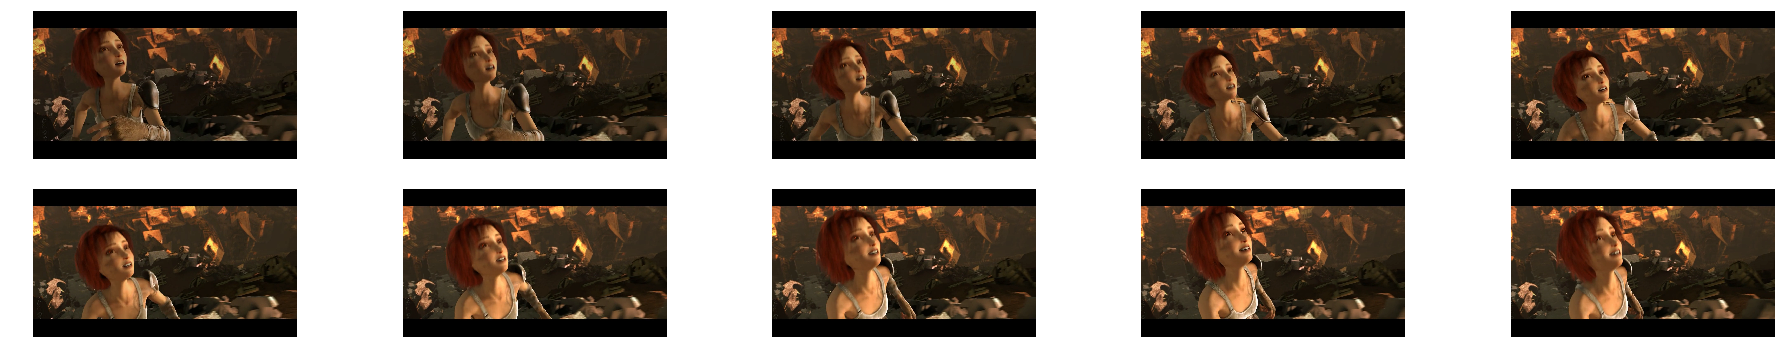

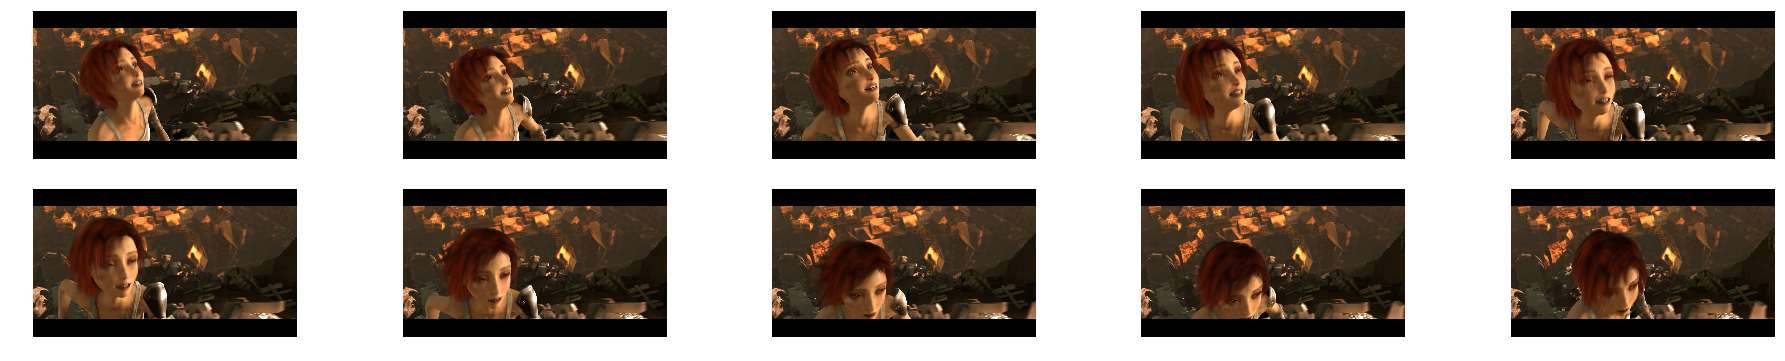

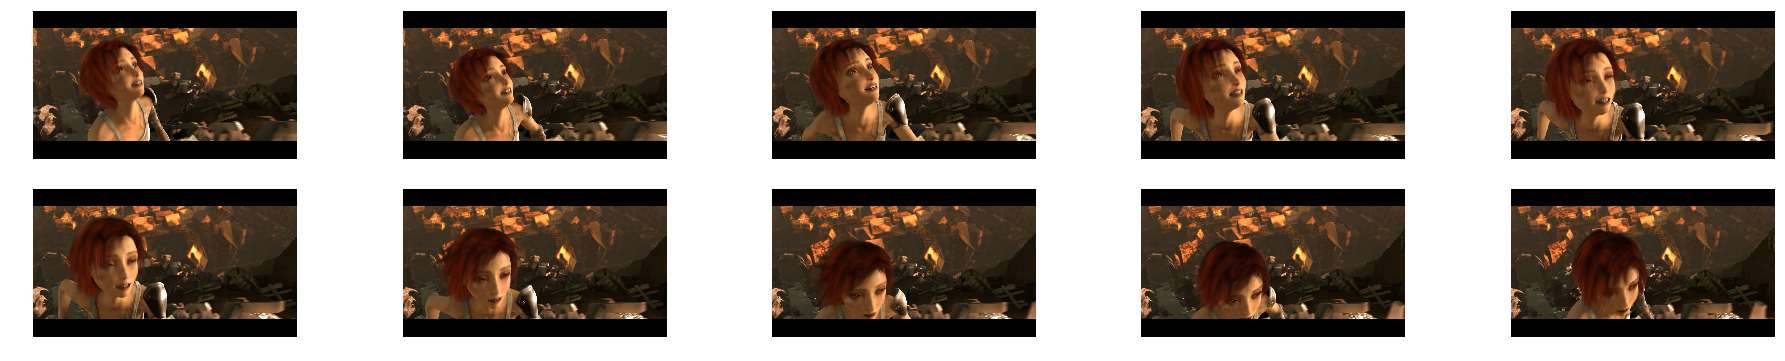

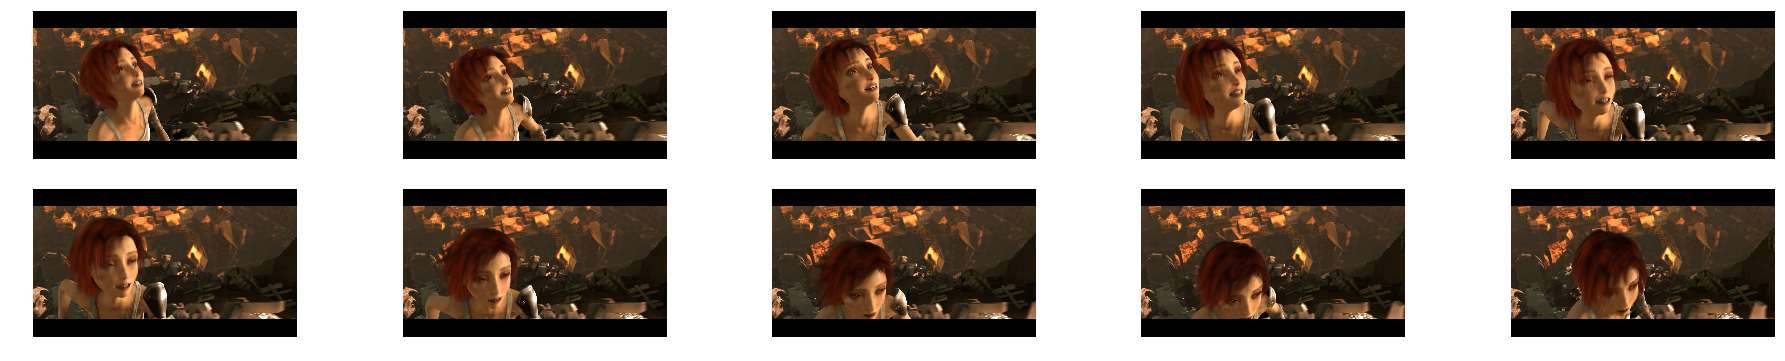

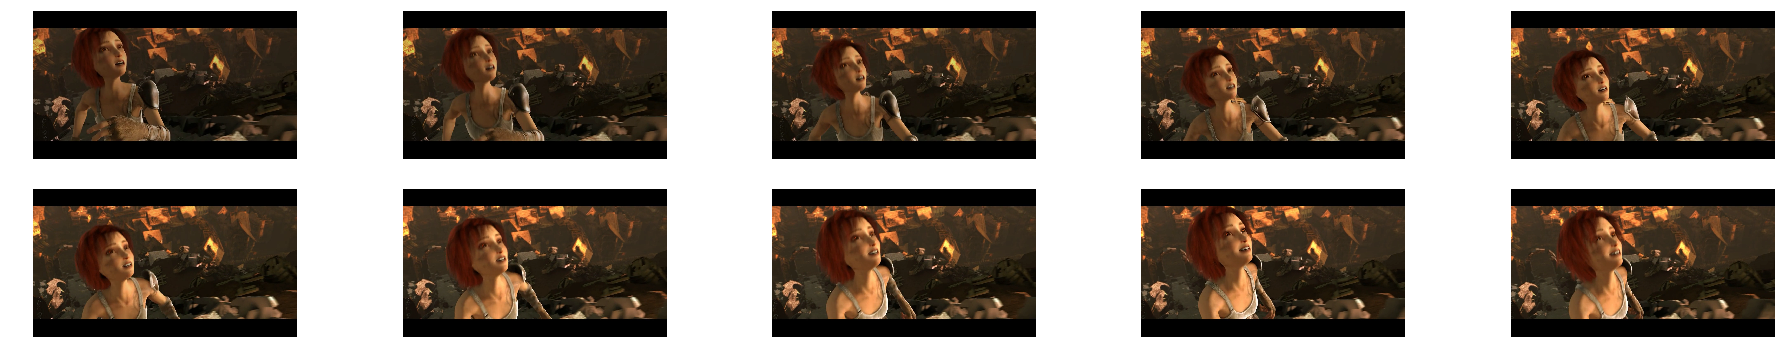

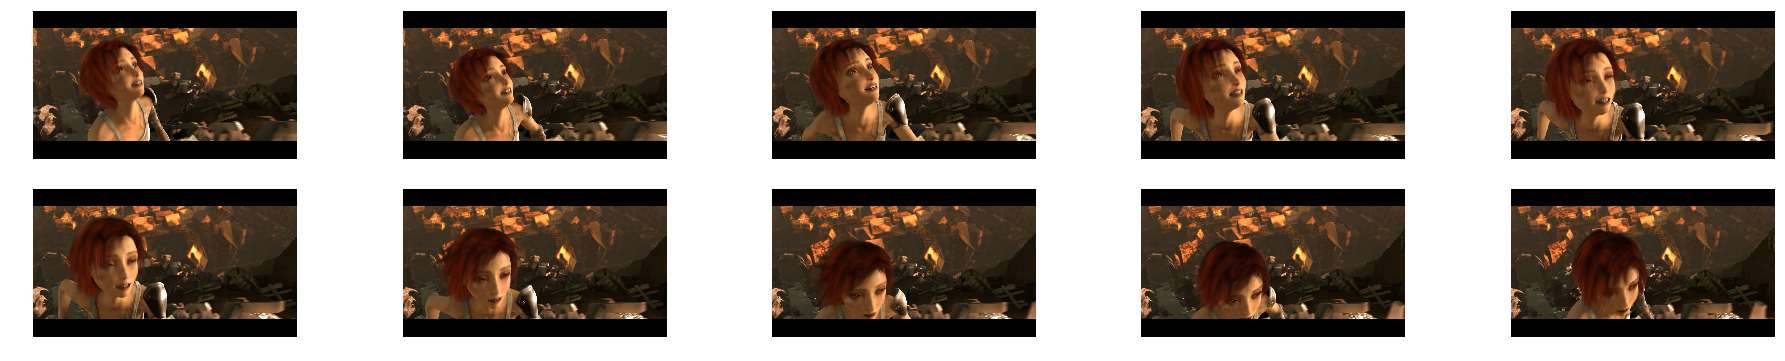

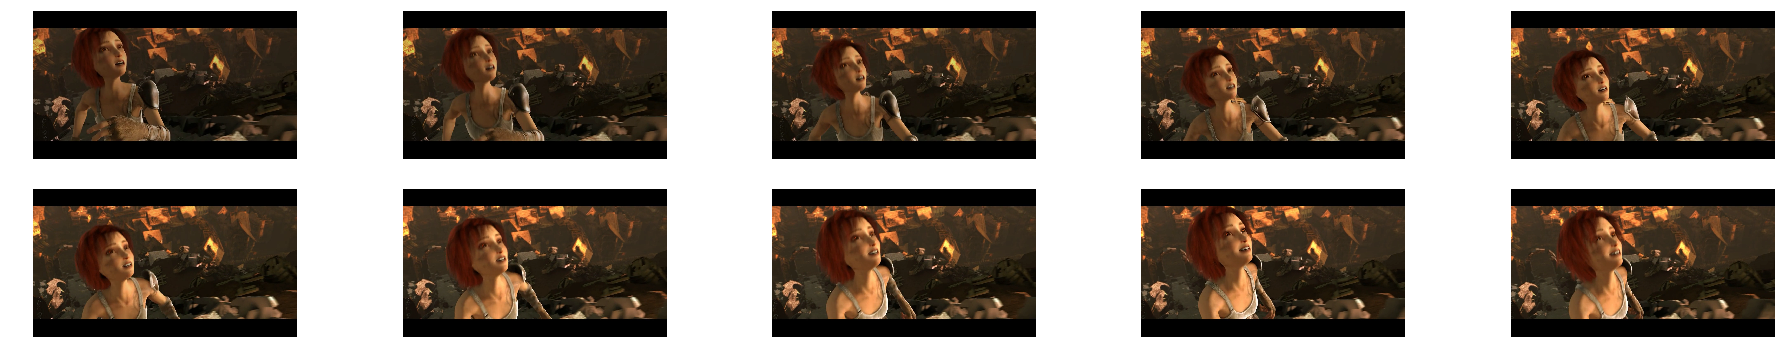

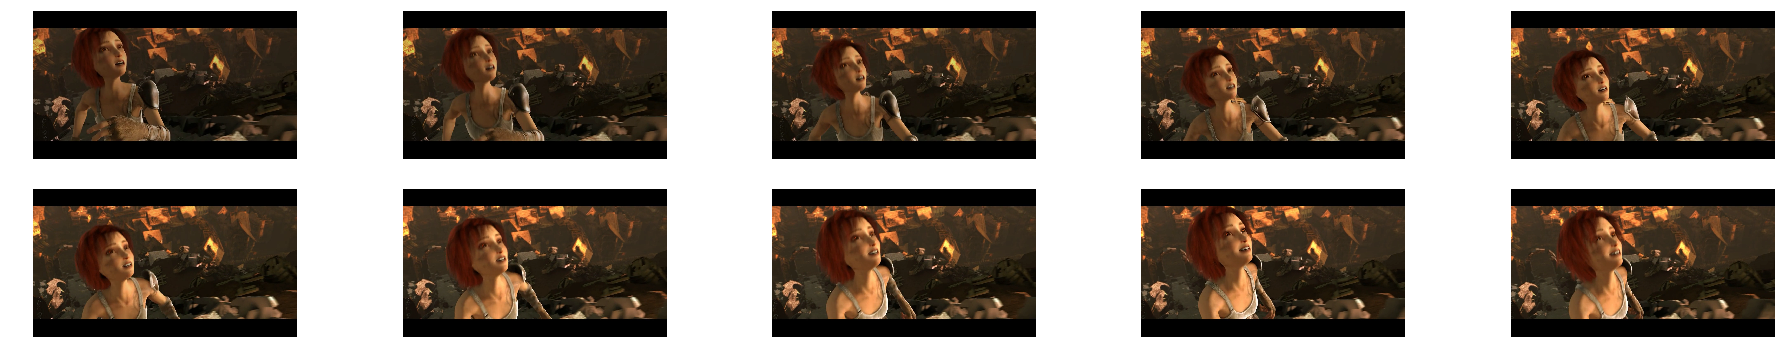

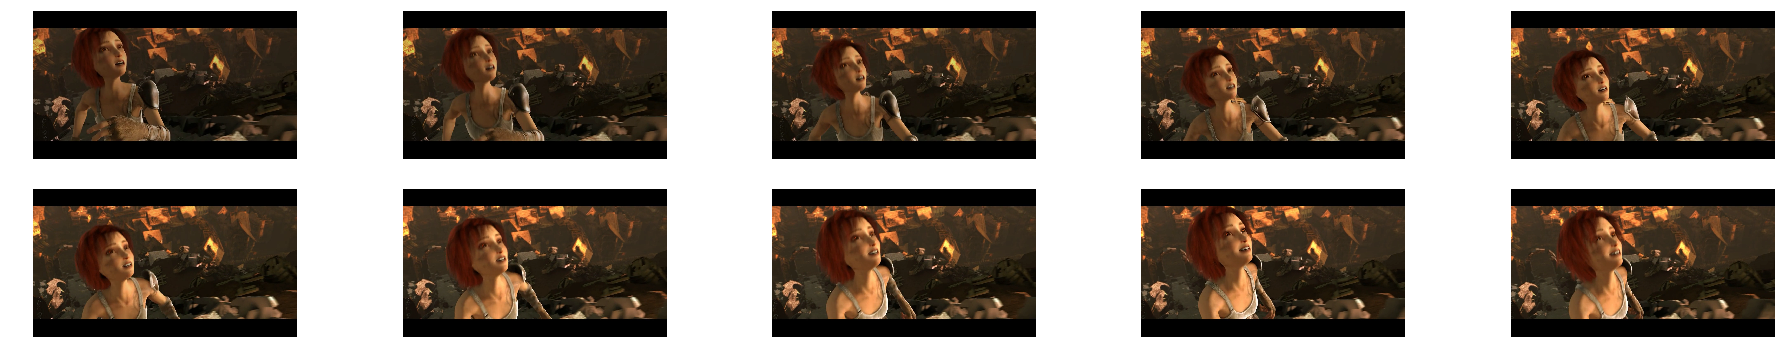

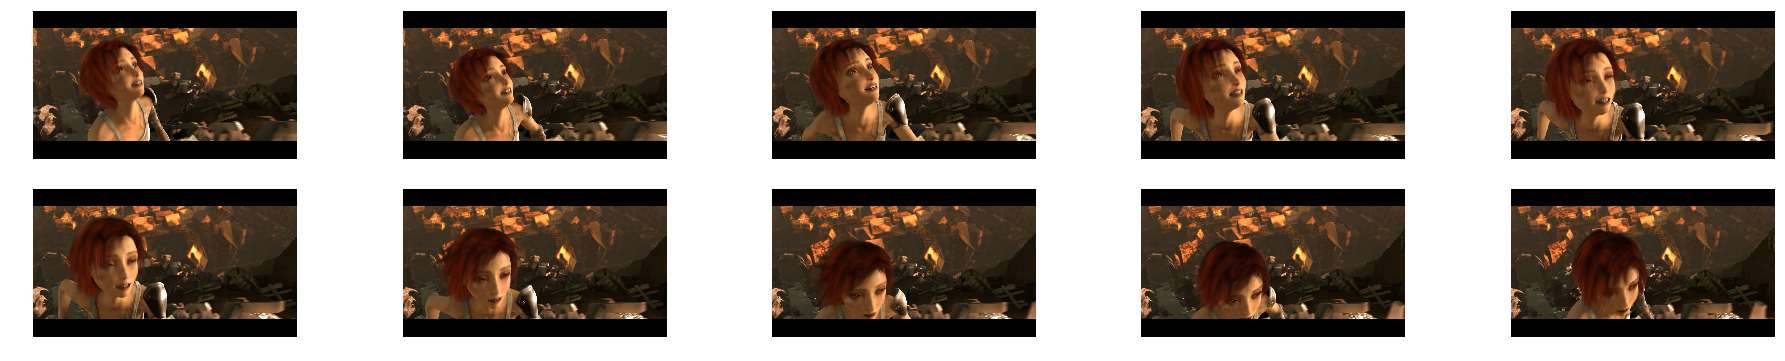

In [6]:
pipe = SequencePipeline(batch_size, 1, 0)
pipe.build()

for i in range(n_iter):
    print("Iteration " + str(i))
    pipe_out = pipe.run()
    sequences_out = pipe_out[0].as_array()
    print(sequences_out.shape)
    show_sequence(sequences_out[0])